<a href="https://www.kaggle.com/code/samithsachidanandan/garbage-classification-transfer-learning?scriptVersionId=292259798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
a2a-sdk 0.3.22 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.1 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.

# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from PIL import Image 
from pathlib import Path

import warnings 
warnings.filterwarnings('ignore') 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from sklearn.model_selection import train_test_split 
from datasets import load_dataset 
import fasttext 

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2026-01-16 18:41:38.248045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768588898.460616      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768588898.525496      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768588899.040415      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768588899.040467      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768588899.040470      24 computation_placer.cc:177] computation placer alr

# Loading the Data

In [3]:
train_dir = Path('/kaggle/input/garbage-classification/Garbage classification/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/kaggle/input/garbage-classification/Garbage classification/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))


val_dir = Path('/kaggle/input/garbage-classification/Garbage classification/val')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))


In [4]:
def proc_img(filepath):
  

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

   
    df = pd.concat([filepath, labels], axis=1)

 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# Basic Stats 

In [5]:
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

print("\nUnique classes:", train_df['Label'].nunique())
print("Classes:\n", train_df['Label'].unique())

Train shape: (2527, 2)
Validation shape: (2527, 2)
Test shape: (2527, 2)

Unique classes: 6
Classes:
 ['metal' 'glass' 'cardboard' 'paper' 'plastic' 'trash']


# Class Distribution 

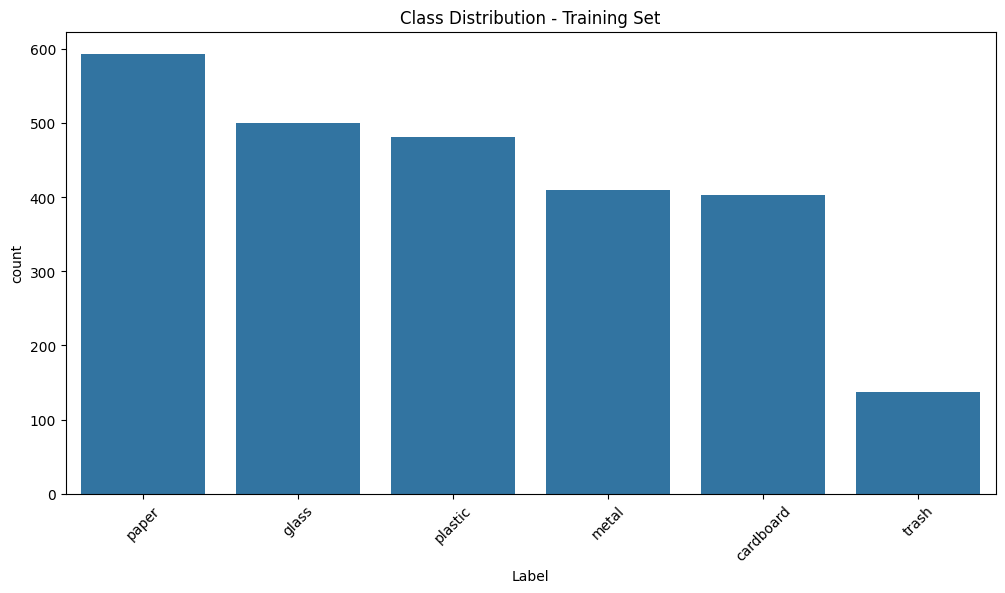

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(data=train_df, x='Label', order=train_df['Label'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Class Distribution - Training Set")
plt.show()

There is a moderate imbalance in the class as we can see the trash class is having less samples and this will cause biase towards the majority class. 

# Distribution across Train Test and Val

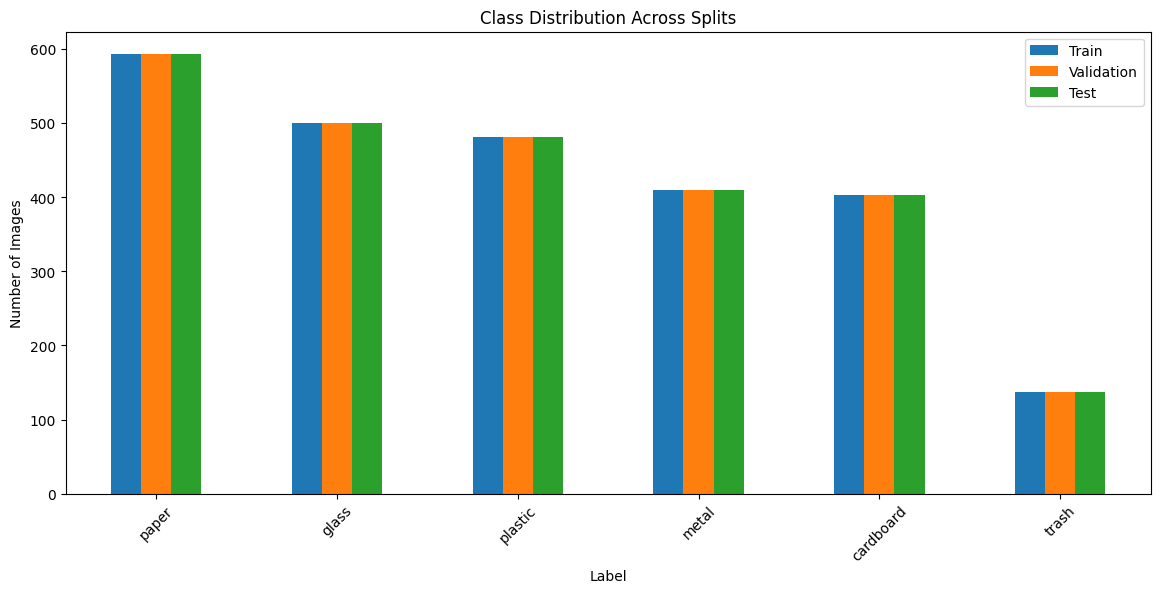

In [7]:
dist_df = pd.DataFrame({
    'Train': train_df['Label'].value_counts(),
    'Validation': val_df['Label'].value_counts(),
    'Test': test_df['Label'].value_counts()
}).fillna(0)

dist_df.plot(kind='bar', figsize=(14,6))
plt.title("Class Distribution Across Splits")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

Since the distribution across splits and equal there won't be any risk of data distribution bias

# Image Resolution

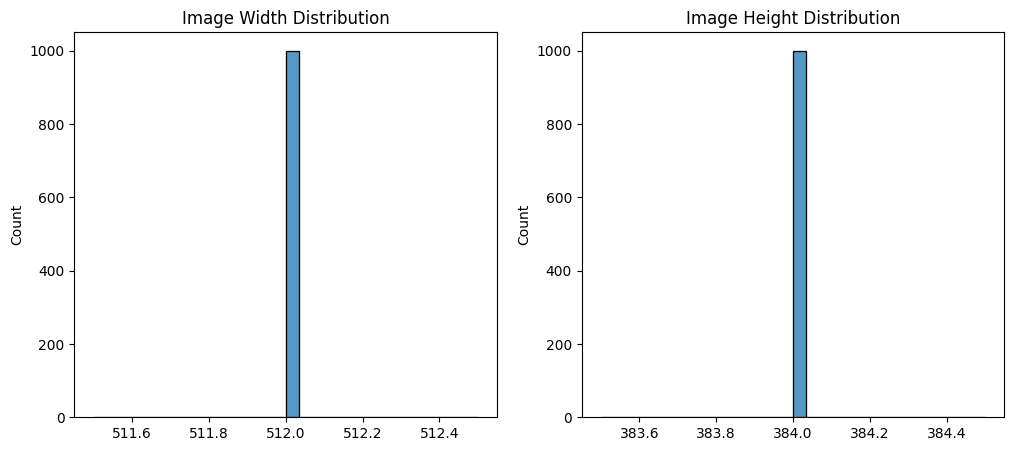

In [8]:
def get_image_sizes(df, sample_size=1000):
    widths, heights = [], []
    
    for img_path in df['Filepath'].sample(sample_size):
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        
    return widths, heights

widths, heights = get_image_sizes(train_df)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(widths, bins=30)
plt.title("Image Width Distribution")

plt.subplot(1,2,2)
sns.histplot(heights, bins=30)
plt.title("Image Height Distribution")

plt.show()

No resolution variance across the dataset

# Aspect Ratio

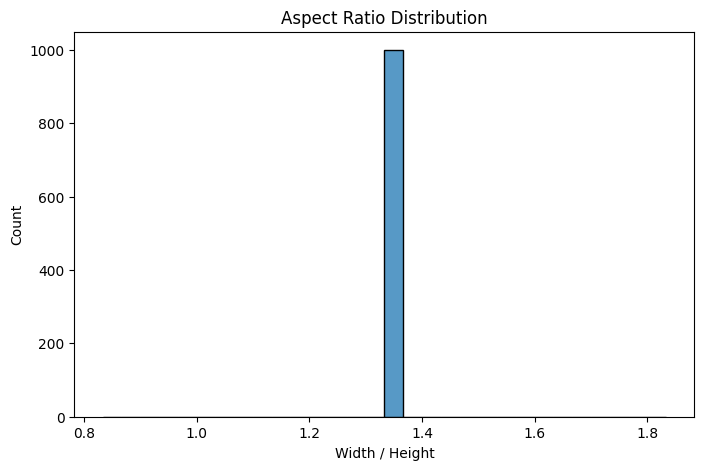

In [9]:
aspect_ratios = np.array(widths) / np.array(heights)

plt.figure(figsize=(8,5))
sns.histplot(aspect_ratios, bins=30)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.show()

Aspect Ratio looks is ok

# Sample Images

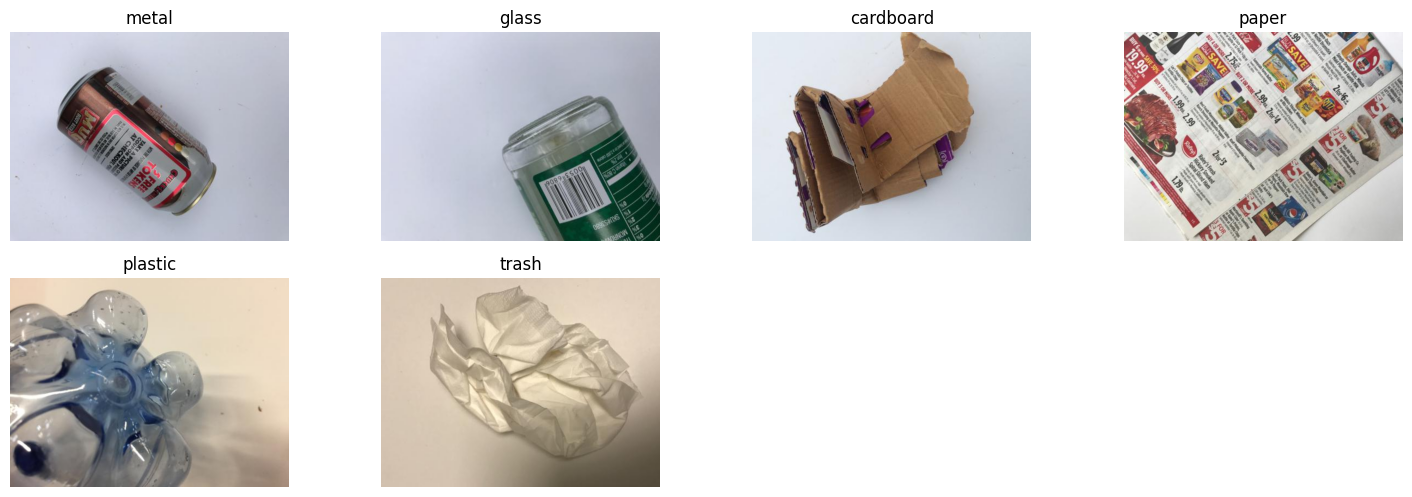

In [10]:
plt.figure(figsize=(15,10))

for i, label in enumerate(train_df['Label'].unique()):
    img_path = train_df[train_df['Label'] == label]['Filepath'].iloc[0]
    img = Image.open(img_path)
    
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Random Samples 

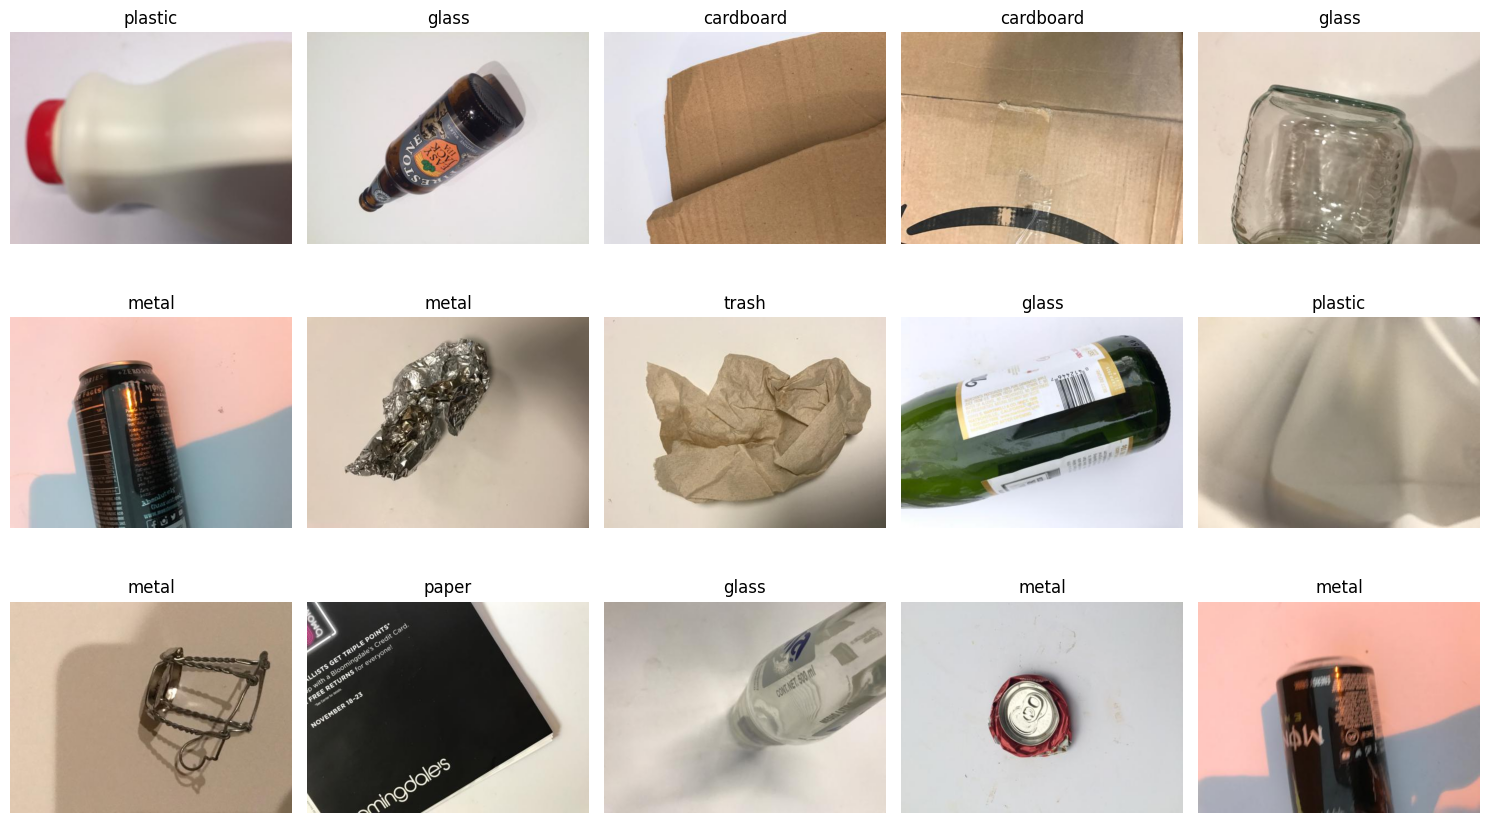

In [11]:
fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ax in axes.flatten():
    row = train_df.sample(1).iloc[0]
    img = Image.open(row['Filepath'])
    ax.imshow(img)
    ax.set_title(row['Label'])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Color Channel Distribution

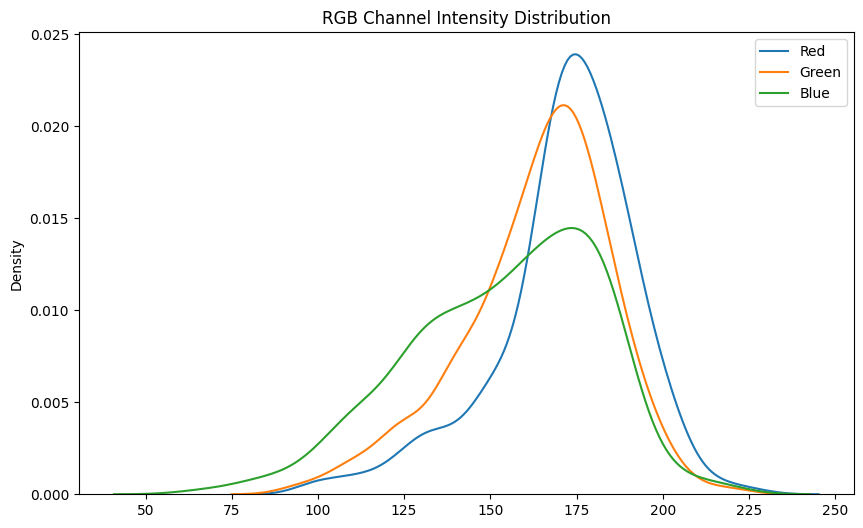

In [12]:
def get_rgb_stats(df, sample_size=500):
    r, g, b = [], [], []
    
    for img_path in df['Filepath'].sample(sample_size):
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        
        r.append(img[:,:,0].mean())
        g.append(img[:,:,1].mean())
        b.append(img[:,:,2].mean())
        
    return r, g, b

r, g, b = get_rgb_stats(train_df)

plt.figure(figsize=(10,6))
sns.kdeplot(r, label='Red')
sns.kdeplot(g, label='Green')
sns.kdeplot(b, label='Blue')
plt.title("RGB Channel Intensity Distribution")
plt.legend()
plt.show()

# Corrupted Images

In [13]:
from PIL import UnidentifiedImageError

def check_corrupt_images(df):
    corrupt = []
    for path in df['Filepath']:
        try:
            Image.open(path).verify()
        except (UnidentifiedImageError, IOError):
            corrupt.append(path)
    return corrupt

corrupt_images = check_corrupt_images(train_df)
print("Corrupted images:", len(corrupt_images))


Corrupted images: 0


# Config

In [14]:
IMG_SIZE = (224, 224)  
BATCH_SIZE = 64
SEED = 42


# Train - Test - Split

In [15]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',  
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='categorical', 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical', 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2527 files belonging to 6 classes.


I0000 00:00:1768588935.376420      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2527 files belonging to 6 classes.
Found 2527 files belonging to 6 classes.


In [16]:
class_names = train_ds_raw.class_names
num_classes = len(class_names)

In [17]:
batch = next(train_ds_raw.as_numpy_iterator())

In [18]:
batch[0].shape

(64, 224, 224, 3)

In [19]:
class_names = train_ds_raw.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Normalization

In [20]:
train_ds = train_ds_raw.map(lambda x, y: (x/255,y))
test_ds = test_ds_raw.map(lambda x, y: (x/255,y))
val_ds = val_ds_raw.map(lambda x, y: (x/255,y))

# Data Augmentation

In [21]:
TRASH_IDX = class_names.index('trash')
METAL_IDX = class_names.index('metal')
CARDBOARD_IDX = class_names.index('cardboard')

In [22]:
moderate_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

strong_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [23]:
def apply_classwise_augmentation(images, labels):
  
    def augment_single(image_label_pair):
        image, label = image_label_pair
        class_idx = tf.argmax(label, axis=-1) 
        
        is_trash = tf.equal(class_idx, TRASH_IDX)
        is_metal_or_cardboard = tf.logical_or(
            tf.equal(class_idx, METAL_IDX),
            tf.equal(class_idx, CARDBOARD_IDX)
        )
        
        image = tf.cond(
            is_trash,
            lambda: strong_augment(image),
            lambda: tf.cond(
                is_metal_or_cardboard,
                lambda: moderate_augment(image),
                lambda: image
            )
        )
        return image, label
    
   
    images, labels = tf.map_fn(
        augment_single,
        (images, labels),
        fn_output_signature=(
            tf.TensorSpec(shape=images.shape[1:], dtype=tf.float32),
            tf.TensorSpec(shape=labels.shape[1:], dtype=tf.float32)
        )
    )
    return images, labels


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    apply_classwise_augmentation,
    num_parallel_calls=AUTOTUNE
)

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# Model 

In [25]:
input_shape = batch[0].shape[1:] 


base_model = tf.keras.applications.MobileNetV2(
            weights='imagenet',
            input_shape=input_shape,
            include_top=False
        )
base_model.trainable = False

model = tf.keras.Sequential([
    layers.InputLayer(shape=input_shape),
    base_model,

    layers.GlobalAveragePooling2D(),
   
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,126 (10.00 MB)

 Trainable params: 362,374 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

# Training

In [28]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [29]:
history = model.fit(
    train_ds,
    epochs=30, 
    validation_data=val_ds,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30


I0000 00:00:1768588960.632121      79 service.cc:152] XLA service 0x7872a8002b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768588960.632160      79 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768588962.078146      79 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768588970.668506      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 609ms/step - accuracy: 0.5508 - loss: 1.3832 - val_accuracy: 0.6945 - val_loss: 0.8033
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.8703 - loss: 0.3433 - val_accuracy: 0.7689 - val_loss: 0.6447
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9097 - loss: 0.2505 - val_accuracy: 0.8251 - val_loss: 0.5468
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.9321 - loss: 0.1886 - val_accuracy: 0.8358 - val_loss: 0.5333
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9489 - loss: 0.1443 - val_accuracy: 0.8223 - val_loss: 0.6171
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9630 - loss: 0.1227 - val_accuracy: 0.8350 - val_loss: 0.5626
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9707 - loss: 0.0961 - val_accuracy: 0.8346 - val_loss: 0.5951
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9688 - loss: 0.0891 - val_accuracy: 0.8314 - val

In [30]:
scores = model.evaluate(test_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8876 - loss: 0.3626


In [31]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 87.42%


# Results

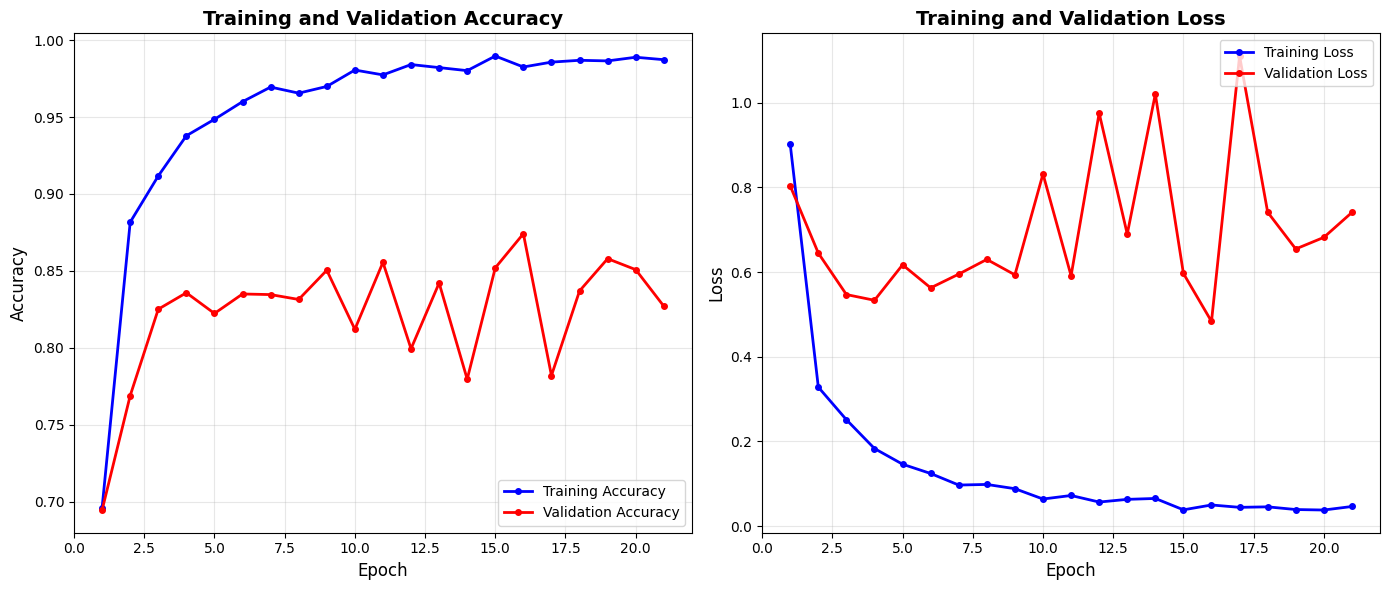


Training Summary:
Total epochs trained: 21
Best validation accuracy: 0.8742 (Epoch 16)
Final training accuracy: 0.9873
Final validation accuracy: 0.8271
Final training loss: 0.0463
Final validation loss: 0.7407



In [32]:

def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)

In [33]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [34]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.97      0.86      0.91       403
       glass       0.82      1.00      0.90       501
       metal       0.97      0.70      0.81       410
       paper       0.82      1.00      0.90       594
     plastic       0.88      1.00      0.94       482
       trash       1.00      0.01      0.03       137

    accuracy                           0.87      2527
   macro avg       0.91      0.76      0.75      2527
weighted avg       0.89      0.87      0.85      2527

